In [ ]:
import tensorflow as tf
from keras.api.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.api.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

# 1. Завантажив та відготував датасет (зменшив через технічні обмеження)
(x_train, _), (_, _) = fashion_mnist.load_data()
x_train = x_train[:10000] / 255.0
x_train = np.expand_dims(x_train, axis=-1)

BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(BATCH_SIZE)

In [ ]:
# 2. генератор
def build_generator():
    model = tf.keras.Sequential([
        Dense(128, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        LeakyReLU(),
        Dense(7*7*64, use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 64)),
        Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        LeakyReLU(),
        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [ ]:
# 3. дискримінатор
def build_discriminator():
    model = tf.keras.Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        LeakyReLU(),
        Flatten(),
        Dense(1)
    ])
    return model

In [ ]:
# 4. функції втрат та оптимізатори
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# 5. тренування
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
# 6. генерація та збереження зображень
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


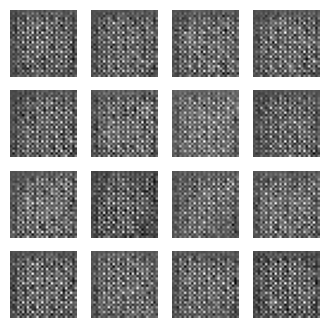

2024-12-21 01:56:50.113790: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


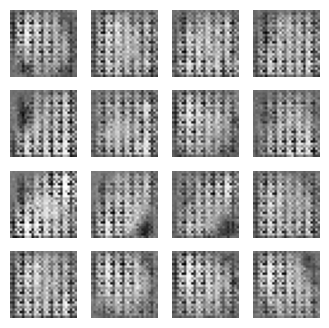

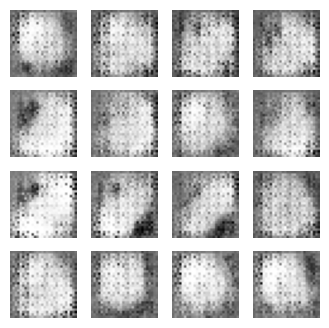

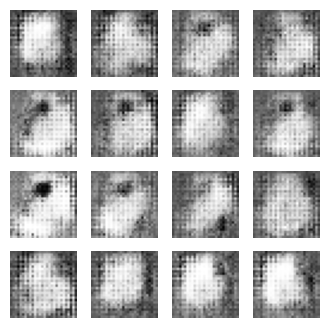

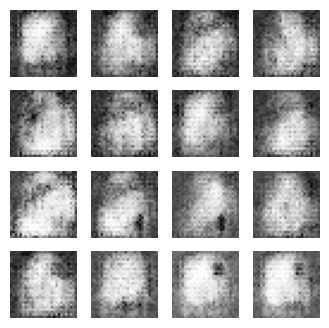

2024-12-21 01:57:02.282125: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


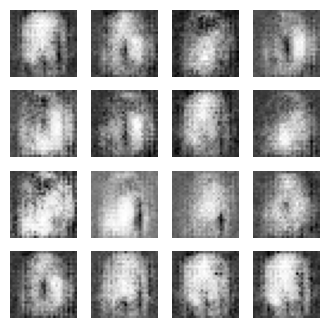

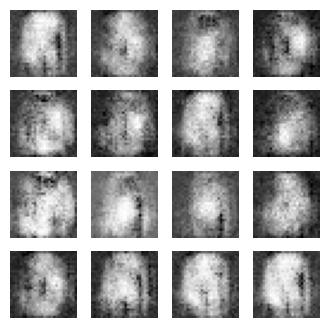

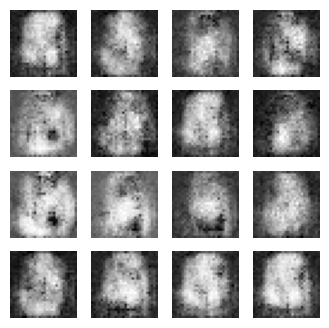

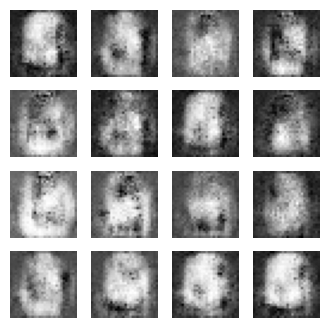

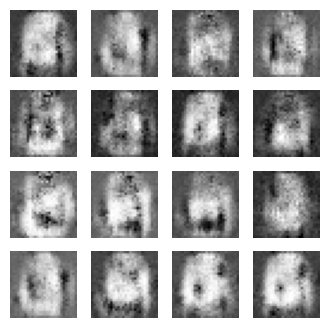

In [ ]:

# 7. Основний цикл
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        generate_and_save_images(generator, epoch + 1, seed)

train(train_dataset, EPOCHS)
